<a href="https://colab.research.google.com/github/MohaMAZ/OCR/blob/main/meds_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-cloud-vision

In [ ]:
from google.cloud import vision_v1p3beta1 as vision
import pandas as pd
from PIL import Image
import re
import io
from google.colab.patches import cv2_imshow
from IPython.display import display

In [ ]:
import os

# Imports Credential File:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "ocr_key.json"
print("Service Account Key: {}".format(os.environ["GOOGLE_APPLICATION_CREDENTIALS"]))

Service Account Key: ocr_key.json


#**Webscrape medicines and their prices to determine the exact names of the medicine in the prescriptions**
**https://github.com/MohaMAZ/webscraping**

In [ ]:
data = pd.read_csv('data.csv')

# **Function to send a request to google vision API**

In [ ]:
def detect_handwritten_ocr(path):
    """Detects handwritten characters in a local image.

    Args:
    path: The path to the local file.
    """
    from google.cloud import vision_v1p3beta1 as vision
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)
    # Language hint codes for handwritten OCR:
    # en-t-i0-handwrit, mul-Latn-t-i0-handwrit
    # Note: Use only one language hint code per request for handwritten OCR.
    image_context = vision.ImageContext(
        language_hints=['fr-t-i0-handwrit'])

    response = client.document_text_detection(image=image,
                                              image_context=image_context)
    return(response)

# **Open target image and crop the content (without header and footer)**







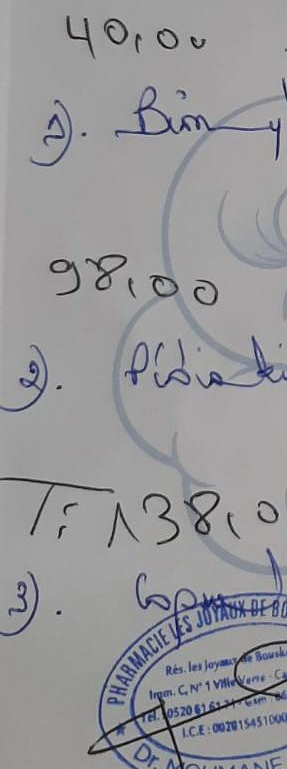

In [ ]:
im = Image.open("2.jpg")
width, height = im.size
left = 0
top = height / 3.5
right = width/3
bottom = 9* (height / 10)
trimmed = im.crop((left,top,right,bottom))
trimmed.save('result.png')
im = Image.open("result.png")
display(im)

#**Send a request to detect the cropped image and turn it to df2**

In [ ]:
response_google = detect_handwritten_ocr("result.png")

In [ ]:
df = pd.DataFrame(columns = ["text","y1","y2","x","lang"])
for page in response_google.full_text_annotation.pages:
  #print(page)
  for block in page.blocks:
    for paragraph in block.paragraphs:
      for word in paragraph.words:
        word_text = ''.join([symbol.text for symbol in word.symbols])
        y1 = word.bounding_box.vertices[3].y
        y2 = word.bounding_box.vertices[0].y
        x_value = word.bounding_box.vertices[3].x
        if word.property.detected_languages == []:
          language = "NaN"
        else:
          language = word.property.detected_languages[0].language_code
        new_row = {'text':word_text, 'y1':y1,'y2':y2,'x':x_value, 'lang':language}
        df = df.append(new_row, ignore_index=True)
pd.set_option('display.max_rows', df.shape[0]+1)
df.sort_values(by=['y1','x']).reset_index(drop=True)

,text,y1,y2,x,lang
0,"40,00",50,14,61,NaN
1,Bim,145,92,116,en
2,y,155,120,262,NaN
3,2.,160,106,38,en
4,"98,00",292,249,41,NaN
5,Pidia,382,341,123,fi
6,ki,382,341,242,fi
7,2,403,346,10,NaN
8,.,403,346,49,NaN
9,Ti,542,482,8,yo


In [ ]:
response_google.text_annotations[0].description.splitlines()

['2. Ligota', '129.50', '3', '79,00', 'Navi', '208 30', 'CVING']

#**Sort values by x and y to detect meds and their prices**

In [ ]:
i = 0
text = []
while i<len(df.text.tolist()):
  lst = [i]
  for k in range(i+1,len(df.text.tolist())):
    if(df.y2.tolist()[k]>df.y1.tolist()[i]):
      break
    else:
      lst.append(k)
  line = " ".join(df.iloc[lst].sort_values(by=['x']).reset_index(drop=True).text.tolist())
  print(line)
  text.append(line)
  i = k
  if(i == len(df.text.tolist())-1):
    break

40,00
2. Bim
98,00
2 . Pidia ki y
Ti 13810
3 ) Gol
PHARMACIE Tel Irm . 0520 LES . C , Nº 61 JOYAUX 1 61 ViVerre DE 80 Ca 6
Rés L.C.E . : 002015451000
Dr les joyauxe Bouska


#**Detect the number of medicines in the prescription**



In [ ]:
m=0
ind = []
for l,i in enumerate(text):
  k=0
  for j in i:
    if j.isdigit():
      k+=1
      if k==2:
        break
  if k==1:
    m+=1
    ind.append(l)

In [ ]:
m

3

#**Detect the handwritten medicines and their prices**

In [ ]:
meds = []
name = []
price = []
for i in text:
  for j in i.split():
    if j.isalpha() :
      name.append(j)
    if len(j)>1:
      if j[0].isdigit() and j[1].isdigit():
        price.append(j)
  if len(name)==m and len(price)==m:
    break
for i in range(m):
  meds.append([name[i],price[i]])

In [ ]:
meds

[['Bim', '40,00'], ['Pidia', '98,00'], ['ki', '13810']]

#**Turn prices from float to int in case if the price is integer because of the format of prices in the data that was scraped (for comparing reasons)**

In [ ]:
for j,i in enumerate(meds):
  if (i[1].endswith(",00") or i[1].endswith(".00") ):
    meds[j][1] = i[1][:-3]
  else:
    if ("." in i[1]) or ("," in i[1]):
      if i[1].endswith("0"):
        meds[j][1] = i[1][:-1]

In [ ]:
meds

[['Bim', '40'], ['Pidia', '98'], ['Gol', '13810']]

#**Use prices to narrow the potential medicines in the dataset then use string similarity to find the most close medicine that matches the alphabets that were detected, in case the price is not found in the data use both price and name in string similarity(loop over the entire dataset)**

In [ ]:
from difflib import SequenceMatcher
temp = []
temp1 = []
meds1 = []
d = 0
for i in meds:
  data1 = data[data.Price == float(i[1])].reset_index()
  if not data1.empty:
    temp = []
    for j in data1.Name.tolist():
      temp.append(SequenceMatcher(None,i[0].upper(), j.split()[0][0:len(i[0])]).ratio())
    meds1.append(data1.Name.tolist()[temp.index(max(temp))])
  else:
    temp1 = []
    for l,p in enumerate(data.Price.tolist()):
      temp1.append((SequenceMatcher(None,i[1], str(p)).ratio()+SequenceMatcher(None,i[0].upper(), data.Name.tolist()[l].split()[0][0:len(i[0])]).ratio()))/2
    meds1.append(data.Name.tolist()[temp1.index(max(temp1))])

#**As you see both 1st and 2nd meds were detected correctly, the 3rd one was not detected because it's not in the dataset**

In [ ]:
meds1

['BIOMYLASE 200 UCEIP / ML,  Sirop',
 'PEDIAKID, Solution buvable',
 'POLYNORM 2 MG, Comprimé pelliculé']